<a href="https://colab.research.google.com/github/JLaura011/Business-Analytics/blob/master/Sesi%C3%B3n_7_Series_de_tiempo_te%C3%B3rico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sesión 7: Series de Tiempo Teórico**



<img src="https://www.grupolambda.com.pe/wp-content/uploads/2020/03/home-logo.png" alt="drawing" width="300"/>
<br>

 ##### Docente: Jorge Brian Alarcon Flores 

# Series de tiempo
- Una serie temporal es un conjunto secuencial de puntos de datos, medidos típicamente en tiempos sucesivos.
- Se define matemáticamente como un conjunto de vectores x (t), t = 0,1,2, ... donde t representa el tiempo transcurrido.
- La variable x (t) se trata como una variable aleatoria.
- Las medidas tomadas durante un evento en una serie de tiempo se organizan en un orden cronológico adecuado.
- Una serie de tiempo que contiene registros de una sola variable se denomina univariada y más de una variable es multivariada.

# Casos de uso comercial de pronósticos de series de tiempo
- __Previsión de ventas - Previsión de ventas de productos minoristas__
- __Previsión de la demanda: utilizada en la fijación de precios, inventario y gestión de la fuerza laboral__
- __Previsión del tráfico - optimización del transporte y la ruta, diseño de instalaciones viales__
- __Previsión de ingresos - presupuesto, establecimiento de objetivos__

# Importando librería para predicción con series de tiempo

In [ ]:
pip install pyramid-arima

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Importando Data
- Dataset: Pasajeros de aerolínea
- Unidad: Miles

In [ ]:
#Importamos la data
url = 'https://raw.githubusercontent.com/JBrianAlicorp/Business-Analytics/master/international-airline-passengers.csv'
df = pd.read_csv(url,encoding='latin1')

In [ ]:
df.columns = ['year','passengers']

In [ ]:
df.head(3)

,year,passengers
0,1949-02,118
1,1949-03,132
2,1949-04,129


In [ ]:
df.describe()

,passengers
count,143.000000
mean,281.475524
std,119.550851
min,104.000000
25%,180.500000
50%,267.000000
75%,361.000000
max,622.000000


In [ ]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-02
Time period end: 1960-12


In [ ]:
df.shape

(143, 2)

# Preprocesamiento de data y visualización

__Convertimos el formato de fecha:__

In [ ]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

__Establecer índice como la columna de fecha y hora para manipulaciones más fáciles:__

---



In [ ]:
y = df.set_index('year')

In [ ]:
y.index

DatetimeIndex(['1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01', '1949-11-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=143, freq=None)

In [ ]:
y.isnull().sum()

passengers    0
dtype: int64

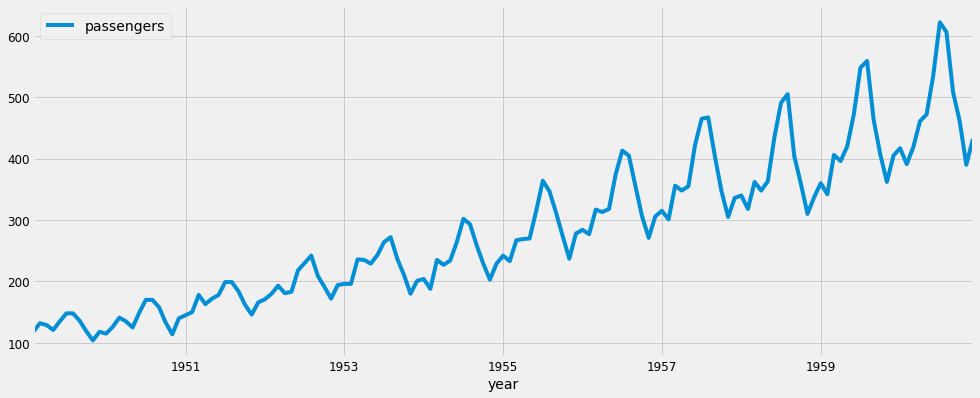

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

__La revisión de los gráficos de la densidad de observaciones puede proporcionar una mayor comprensión de la estructura de los datos:__
- La distribución no es perfectamente gaussiana (distribución normal).
- La distribución se deja desplazada.
- Las transformaciones pueden ser útiles antes del modelado.

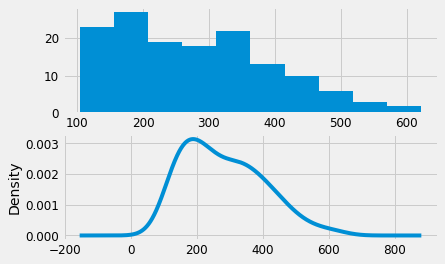

In [ ]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

__Cajas y bigotes:__
- Los valores medianos a través de los años confirman una tendencia al alza
- Aumento constante de la propagación, o 50% medio de los datos (cuadros) con el tiempo
- Un modelo que considere la estacionalidad podría funcionar bien

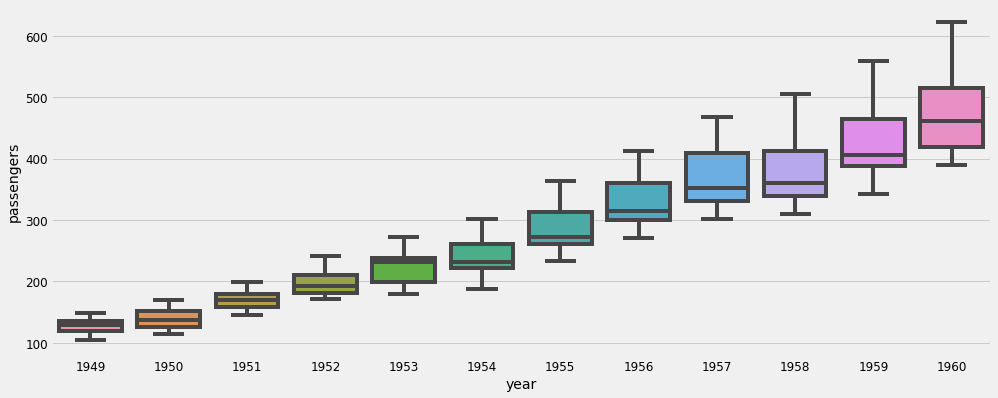

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.year, y.passengers, ax=ax)

__Descomponer usando el modelo de estadísticas:__
- Podemos usar statsmodels para realizar una descomposición de esta serie de tiempo.
- La descomposición de series temporales es una tarea estadística que deconstruye una serie temporal en varios componentes, cada uno de los cuales representa una de las categorías subyacentes de patrones.
- Con los modelos de estadísticas podremos ver los componentes de tendencia, estacionales y residuales de nuestros datos.

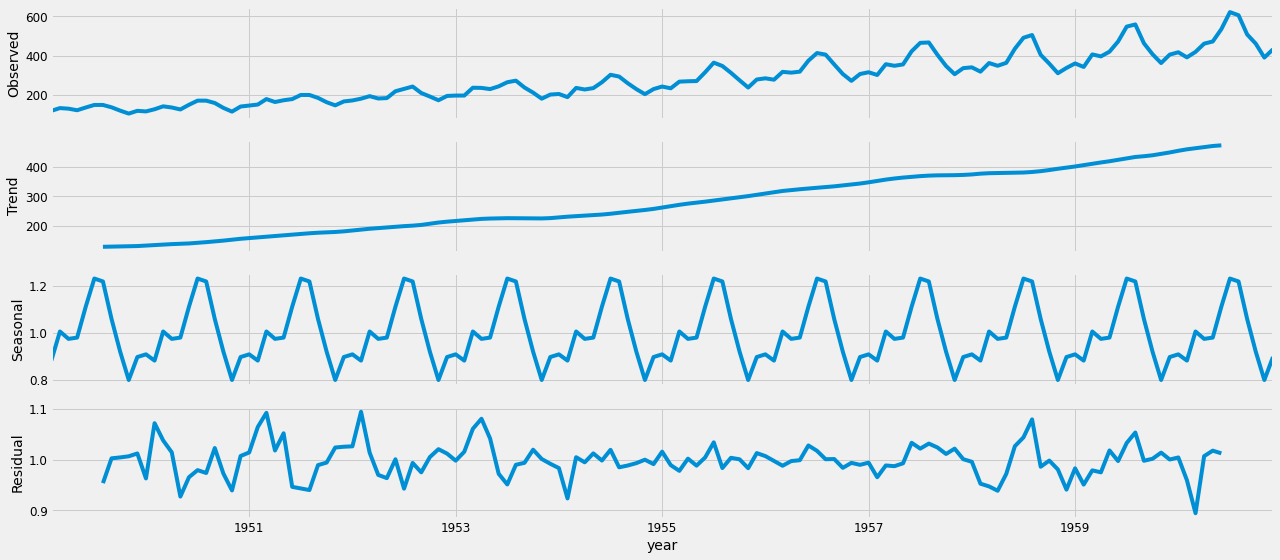

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Estacionariedad
- Se dice que una serie temporal es estacionaria si sus propiedades estadísticas, como la media, la varianza permanecen constantes en el tiempo.
- La mayoría de los modelos de series temporales funcionan bajo el supuesto de que el TS es estacionario. La razón principal de esto es que hay muchas formas en que una serie puede ser no estacionaria, pero solo una forma de estacionariedad.
- Intuitivamente, podemos decir que si una serie temporal tiene un comportamiento particular a lo largo del tiempo, hay una probabilidad muy alta de que siga igual en el futuro.
- Además, las teorías relacionadas con las series estacionarias son más maduras y más fáciles de implementar en comparación con las series no estacionarias.

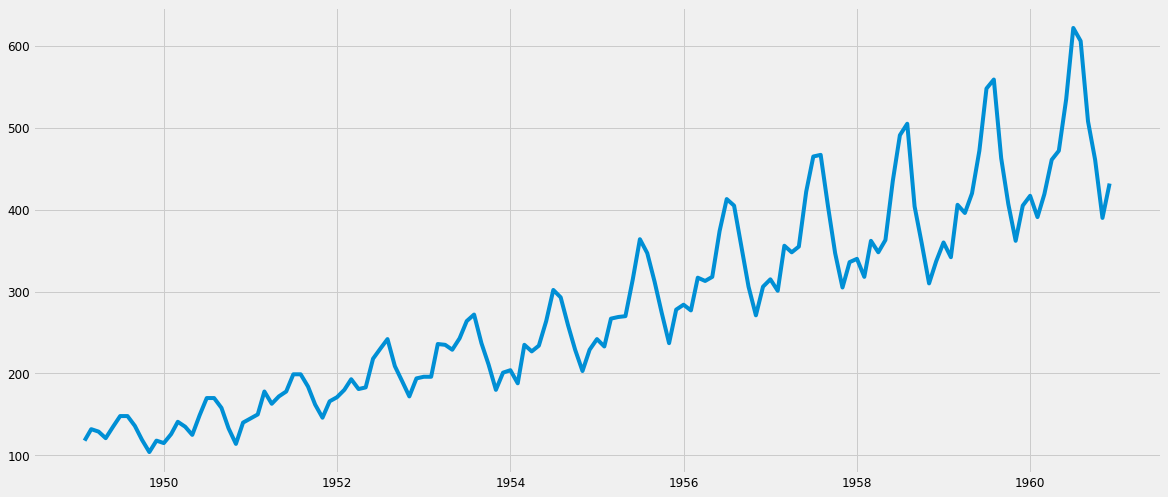

In [ ]:
plt.plot(y)

__Podemos verificar la estacionariedad utilizando lo siguiente:__

- __Gráficos ACF y PACF__: si la serie temporal es estacionaria, los gráficos ACF / PACF mostrarán una __disminución rápida de la correlación__ después de una pequeña cantidad de retraso entre los puntos.
- __Plotting Rolling Statistics__: podemos trazar el promedio móvil o la varianza móvil y ver si varía con el tiempo. La media móvil / varianza es para cualquier "t" instantánea, la media / varianza del último año, es decir, los últimos 12 meses.
- __Prueba de Dickey-Fuller aumentada:__ Esta es una de las pruebas estadísticas para verificar la estacionariedad. Aquí la hipótesis nula es que el TS no es estacionario. Los resultados de la prueba se componen de una estadística de prueba y algunos valores críticos para niveles de confianza diferentes. Si el "Estadístico de prueba" es menor que el "Valor crítico", podemos rechazar la hipótesis nula y decir que la serie es estacionaria. Consulte este artículo para más detalles.

### Gráficos ACF y PACF

- Repasemos los gráficos de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF)
- Si la serie temporal es estacionaria, los gráficos ACF / PACF mostrarán una __disminución rápida de la correlación__ después de una pequeña cantidad de retraso entre los puntos.
- Estos datos no son estacionarios, ya que un gran número de observaciones anteriores están correlacionadas con valores futuros.
- Los intervalos de confianza se dibujan como un cono.
- De forma predeterminada, esto se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este código son muy probablemente una correlación y no una casualidad estadística.
- La autocorrelación parcial en el retraso k es la correlación que resulta después de eliminar el efecto de cualquier correlación debido a los términos en los retrasos más cortos.

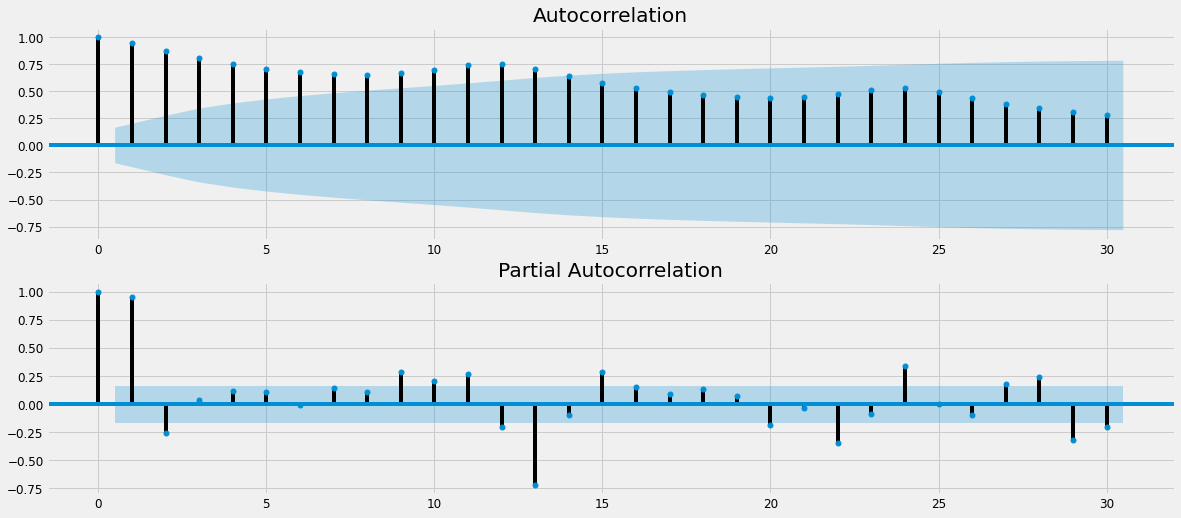

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Graficando estadísticas continuas
- Observamos que la media móvil y la desviación estándar no son constantes con respecto al tiempo (tendencia creciente)
- Por lo tanto, la serie temporal no es estacionaria

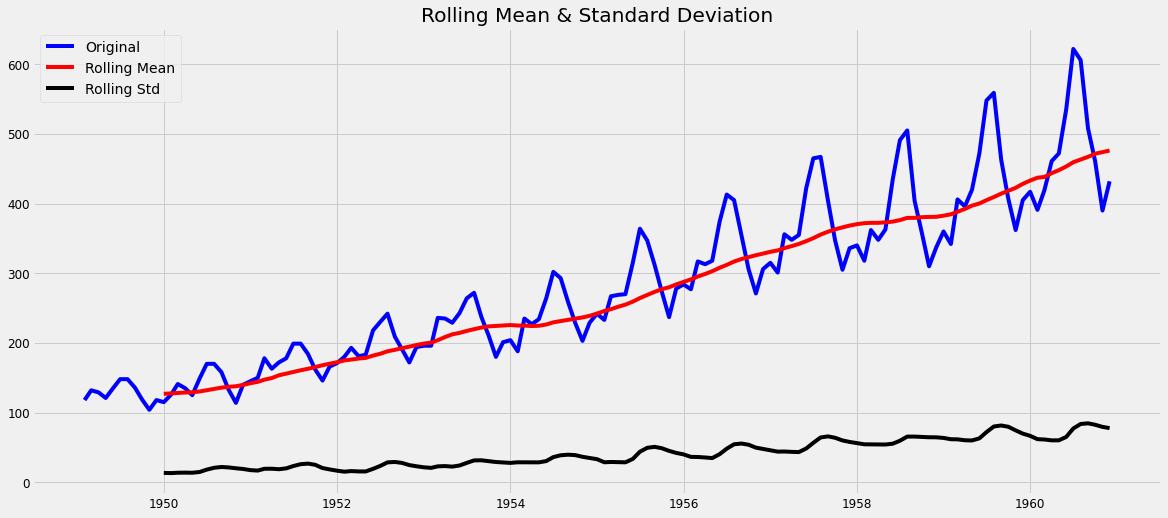

In [ ]:
#Determinar estadísticas continuas
rolmean = y.rolling(12).mean()
rolstd = y.rolling(12).std()

#Graficando estadísticas continuas
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


### Prueba de Dickey-Fuller aumentada
- La intuición detrás de la prueba es que si la serie está integrada, entonces el nivel rezagado de la serie y (t-1) no proporcionará información relevante para predecir el cambio en y (t).
- Hipótesis nula: la serie temporal no es estacionaria
- Rechazar la hipótesis nula (es decir, un valor p muy bajo) indicará estacionariedad

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.792340
p-value                          0.991512
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [ ]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## Hacer series temporales estacionarias
Hay 2 razones principales detrás de la no estacionaria de un TS:

1. __Trend__ - media variable con el tiempo. Por ejemplo, en este caso vimos que, en promedio, el número de pasajeros crecía con el tiempo.
2. __Estacionalidad__ - variaciones en marcos de tiempo específicos. Por ejemplo, las personas pueden tener tendencia a comprar automóviles en un mes en particular debido a un incremento salarial o festivales.

### Transformaciones
- Podemos aplicar transformaciones que penalizan los valores más altos más que los valores más pequeños. Estos pueden tomar un registro, raíz cuadrada, raíz cúbica, etc. Tomemos una transformación de registro aquí por simplicidad:


#### Transformación logarítmica

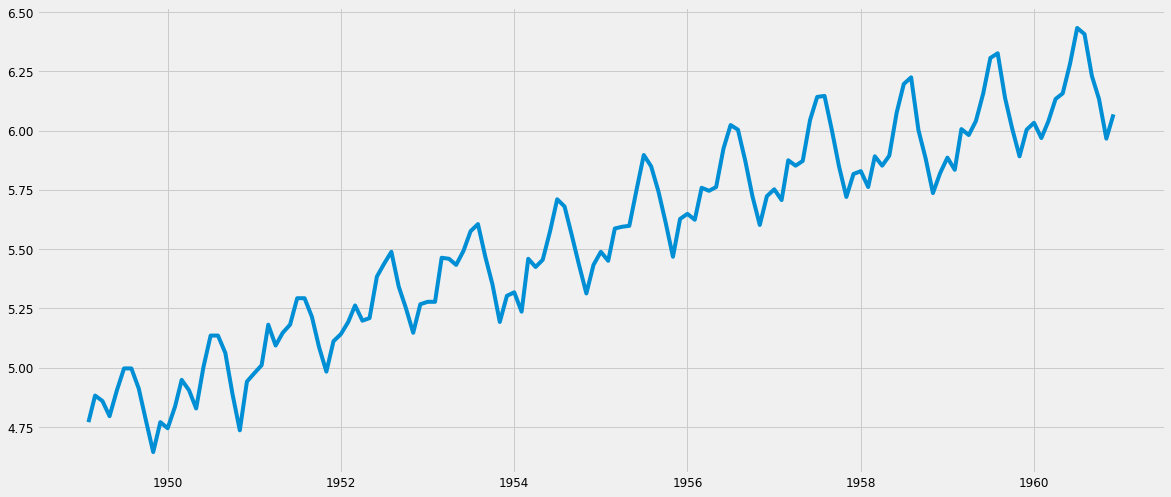

In [ ]:
ts_log = np.log(y)
plt.plot(ts_log)

#### Otras posibles transformaciones:
- Transformación exponencial
- Transformación de Box Cox
- Transformación de raíz cuadrada

### Técnicas para eliminar Tendencia - Suavizado
- Alisar es tomar promedios continuos en ventanas de tiempo

#### Media móvil
- Tomamos un promedio de "k" valores consecutivos dependiendo de la frecuencia de las series de tiempo.
- Aquí podemos tomar el promedio durante el último año, es decir, los últimos 12 valores.
- Un inconveniente de este enfoque particular es que el período de tiempo debe definirse estrictamente.

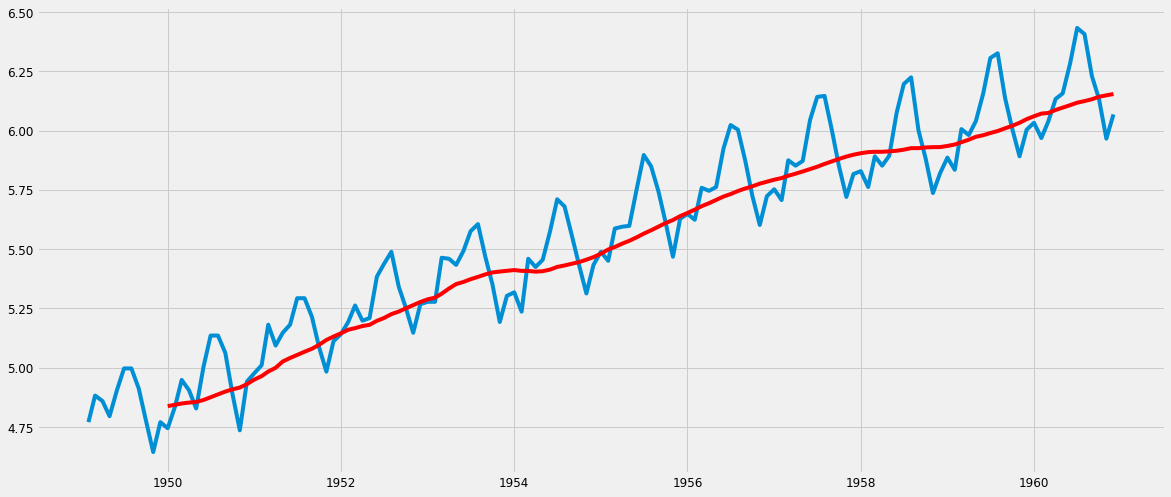

In [ ]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01         NaN
1950-01-01   -0.093449
Name: passengers, dtype: float64

### Técnicas adicionales para eliminar la estacionalidad y la tendencia
- Las técnicas simples de reducción de tendencias discutidas antes no funcionan en todos los casos, particularmente en aquellas con alta estacionalidad. 

#### Diferenciación
- En esta técnica, tomamos la diferencia de la observación en un instante particular con la del instante anterior.
- Diferenciación de primer orden en pandas

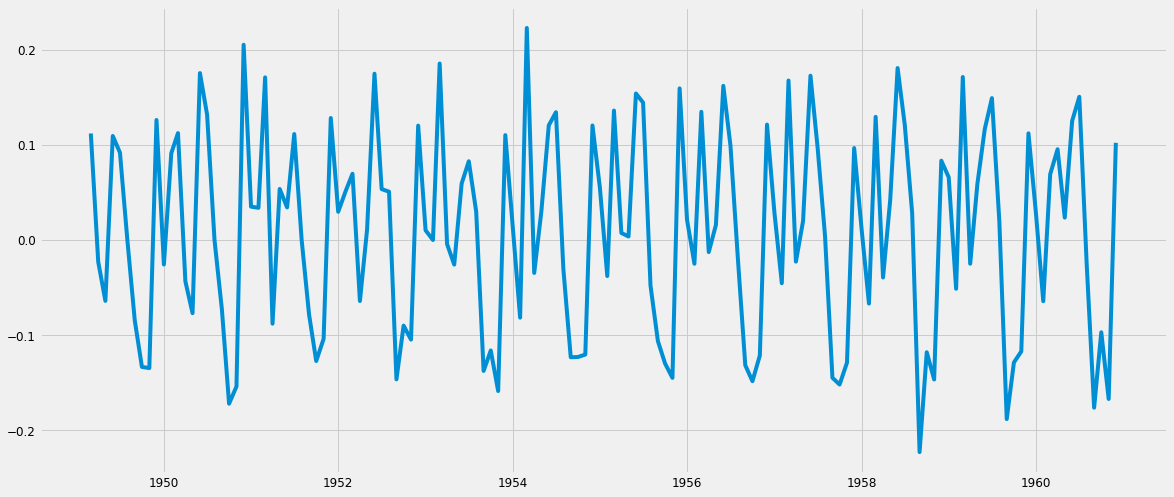

In [ ]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

#### Descomposición
- En este enfoque, tanto la tendencia como la estacionalidad se modelan por separado y se devuelve la parte restante de la serie.

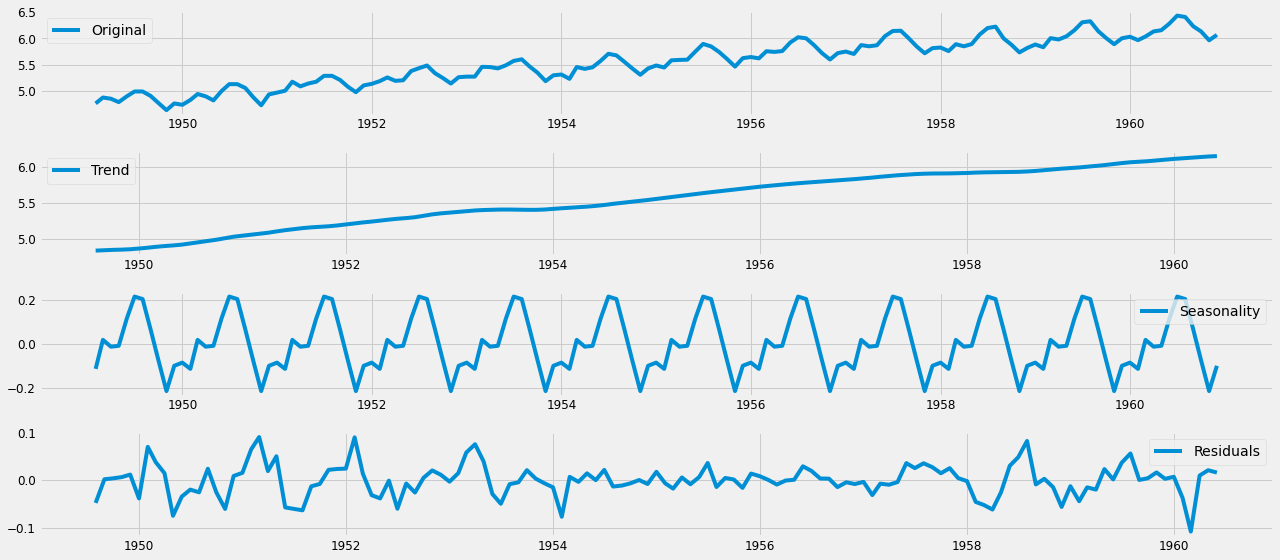

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Predicción de series de tiempo

## Autoregresión (AR)
- El método de autorregresión (AR) modela el siguiente paso de la secuencia como una función lineal de las observaciones en los pasos de tiempo anteriores.
- __Número de términos AR (Auto-regresivos) (p):__ p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x (t) serán x (t-1) ... .x (t-5).

In [ ]:
from statsmodels.tsa.ar_model import AR
from random import random

In [ ]:
ts_log_diff = ts_log_diff.dropna()

In [ ]:
# fit model
model = AR(ts_log_diff)
model_fit = model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



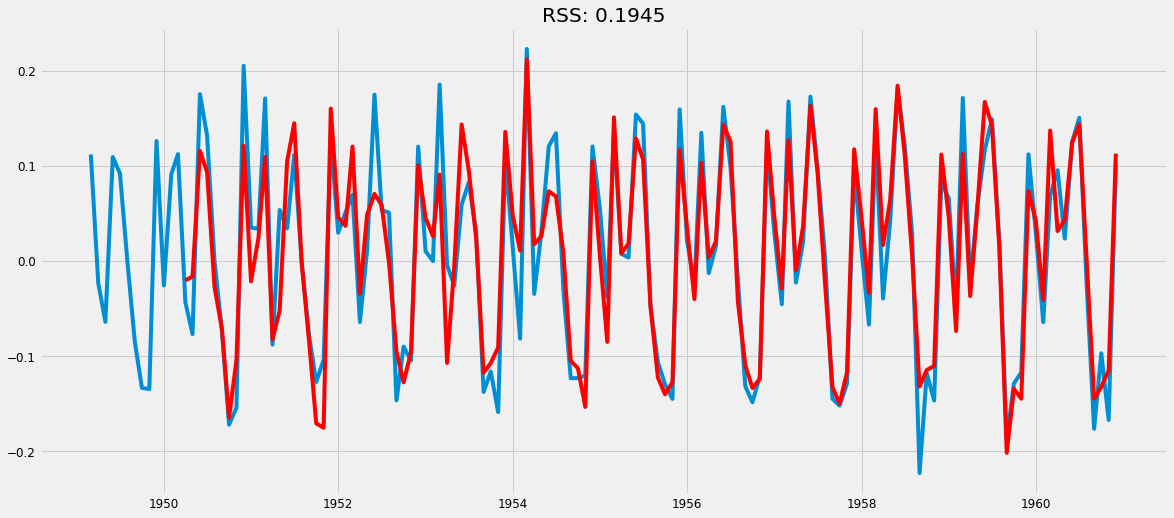

In [ ]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Revirtiendo las transformaciones

__Valores ajustados o predichos:__

In [ ]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

year
1950-04-01   -0.020411
1950-05-01   -0.016294
1950-06-01    0.115849
1950-07-01    0.093439
1950-08-01   -0.027281
dtype: float64


__Suma acumulativa para revertir la diferenciación:__

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

year
1950-04-01   -0.020411
1950-05-01   -0.036705
1950-06-01    0.079144
1950-07-01    0.172582
1950-08-01    0.145301
dtype: float64


__Agregar el valor del primer mes que se eliminó previamente al diferenciar:__

In [ ]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1949-02-01    4.770685
1949-03-01    4.770685
1949-04-01    4.770685
1949-05-01    4.770685
1949-06-01    4.770685
dtype: float64

__Tomando exponente para invertir la transformación del registro:__

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 90.7221')

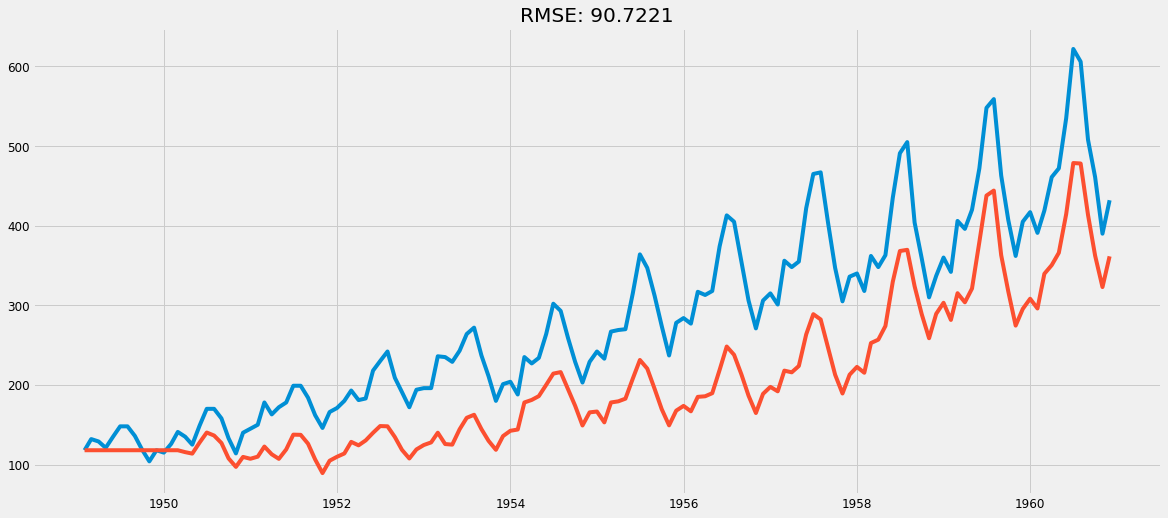

In [ ]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

### Métricas de puntuación de calidad de pronóstico
- __R-cuadrado__
- __Error absoluto medio__
- __Median Absolute Error__
- __Error medio cuadrado__
- __Error logarítmico medio cuadrado__
- __Error medio absoluto de porcentaje__

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

__R cuadrado__, coeficiente de determinación (puede interpretarse como un porcentaje de varianza explicado por el modelo), (-inf, 1]
- sklearn.metrics.r2_score

In [ ]:
r2_score(y.passengers, predictions_ARIMA)

0.4200797482774349

__Mean Absolute Error__, es una métrica interpretable porque tiene la misma unidad de medida que la serie inicial, [0, + inf)
- sklearn.metrics.mean_absolute_error

In [ ]:
mean_absolute_error(y.passengers, predictions_ARIMA)

81.03664850249243

__Median Absolute Error__, nuevamente una métrica interpretable, particularmente interesante porque es robusta para los valores atípicos, [0, + inf)
- sklearn.metrics.median_absolute_error

In [ ]:
median_absolute_error(y.passengers, predictions_ARIMA)

81.187638323567

__Mean Squared Error__, más comúnmente usado, da una penalización mayor a los grandes errores y viceversa, [0, + inf)
- sklearn.metrics.mean_squared_error


In [ ]:
mean_squared_error(y.passengers, predictions_ARIMA)

8230.494506698866

__Error logarítmico medio cuadrado__, prácticamente lo mismo que MSE pero inicialmente tomamos el logaritmo de la serie, como resultado también prestamos atención a pequeños errores, generalmente se usa cuando los datos tienen tendencias exponenciales, [0, + inf)

In [ ]:
mean_squared_log_error(y.passengers, predictions_ARIMA)

0.13468587160499274

__Error medio porcentual absoluto__, igual que MAE pero porcentaje, - muy conveniente cuando desea explicar la calidad del modelo a su gerencia, [0, + inf),
- no implementado en sklearn

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

28.164284491489628

__Función para evaluar el pronóstico utilizando las métricas anteriores:__

In [ ]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [ ]:
evaluate_forecast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.42008,81.036649,81.187638,8230.494507,0.134686,28.164284,90.722073


- RMSE tiene el beneficio de penalizar más errores grandes, por lo que puede ser más apropiado en algunos casos, por ejemplo, si estar apagado por 10 es más del doble de malo que estar apagado por 5. Pero si estar apagado por 10 es el doble de malo como estar apagado a las 5, entonces MAE es más apropiado.

- Desde el punto de vista de la interpretación, MAE es claramente el ganador. RMSE no describe solo el error promedio y tiene otras implicaciones que son más difíciles de descifrar y comprender.

- Por otro lado, una ventaja distintiva de RMSE sobre MAE es que RMSE evita el uso de tomar el valor absoluto, lo que no es deseable en muchos cálculos matemáticos.

## Media móvil (MA)

- __Número de términos MA (promedio móvil) (q):__ q es el tamaño de la ventana de parte del promedio móvil del modelo, es decir, errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.

In [ ]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  142
Model:                     ARMA(0, 1)   Log Likelihood                 120.413
Method:                       css-mle   S.D. of innovations              0.104
Date:                Thu, 11 Jun 2020   AIC                           -234.826
Time:                        23:24:41   BIC                           -225.959
Sample:                    03-01-1949   HQIC                          -231.223
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0096      0.011      0.870      0.386      -0.012       0.031
ma.L1.passengers     0.2709      0.096      2.836      0.005       0.084       0.458
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.6909           +0.0000j            3.6909            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.5249')

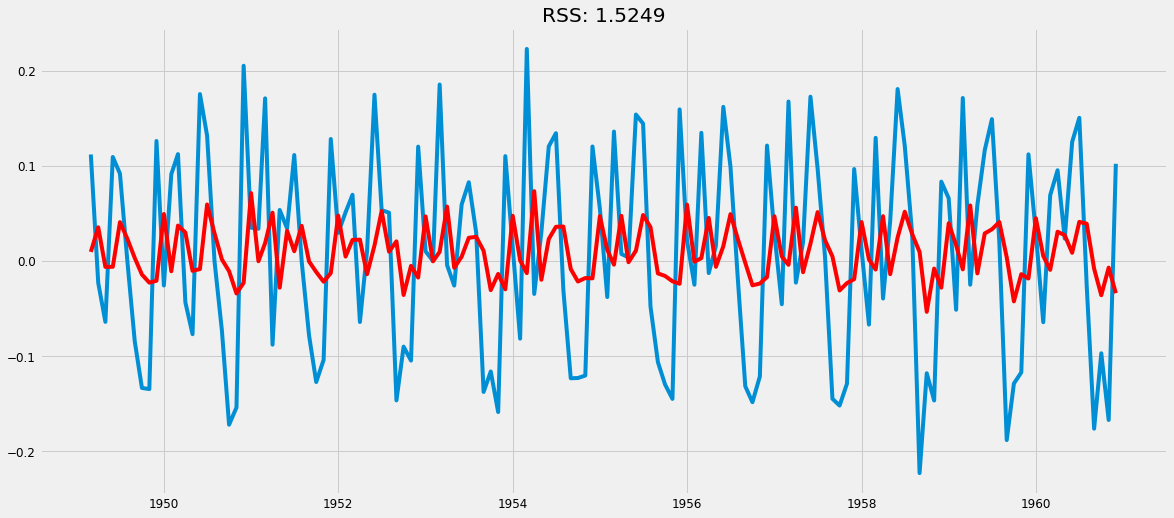

In [ ]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Media móvil autorregresiva (ARMA)

- __Número de términos AR (Auto-regresivos) (p):__ p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x (t) serán x (t-1) ... .x (t-5).
- __Número de términos MA (promedio móvil) (q):__ q es el tamaño de la ventana de parte del promedio móvil del modelo, es decir, errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.


In [ ]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(2, 1))
model_fit = model.fit(disp=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  142
Model:                     ARMA(2, 1)   Log Likelihood                 138.627
Method:                       css-mle   S.D. of innovations              0.090
Date:                Thu, 11 Jun 2020   AIC                           -267.253
Time:                        23:24:42   BIC                           -252.474
Sample:                    03-01-1949   HQIC                          -261.248
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0101      0.000     23.144      0.000       0.009       0.011
ar.L1.passengers     0.9965      0.076     13.055      0.000       0.847       1.146
ar.L2.passengers    -0.4117      0.077     -5.330      0.000      -0.563      -0.260
ma.L1.passengers    -1.0000      0.028    -35.721      0.000      -1.055      -0.945
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2101           -0.9820j            1.5584           -0.1085
AR.2            1.2101           +0.9820j            1.5584            0.1085
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.1767')

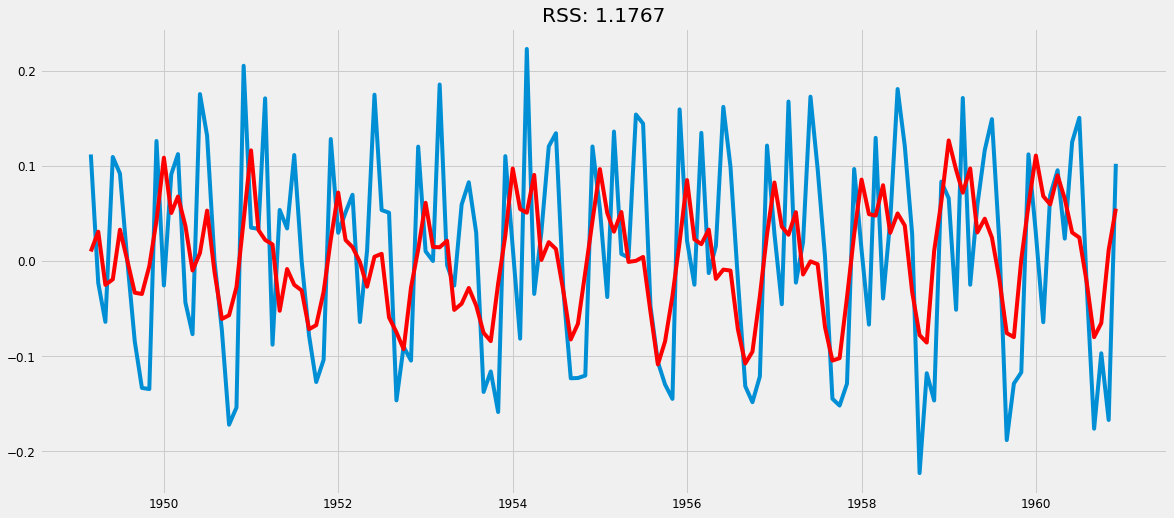

In [ ]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Media móvil integrada autorregresiva (ARIMA)
En un modelo ARIMA hay 3 parámetros que se utilizan para ayudar a modelar los aspectos principales de una serie de tiempo: estacionalidad, tendencia y ruido. Estos parámetros están etiquetados como p, d y q.

- __Número de términos AR (Auto-regresivos) (p):__ p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x (t) serán x (t-1) ... .x (t-5).
- __Número de diferencias (d): __ d es el parámetro asociado con la parte integrada del modelo, que afecta la cantidad de diferencia que se aplica a una serie de tiempo.
- __Número de términos MA (promedio móvil) (q):__ q es el tamaño de la ventana de parte del promedio móvil del modelo, es decir, errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.

<br> __Observaciones de EDA en la serie temporal:__
- La no estacionariedad implica que se requiere al menos un nivel de diferencia (d) en ARIMA
- [El siguiente paso es seleccionar los valores de retraso para los parámetros de Autoregresión (AR) y Media móvil (MA), p y q respectivamente, utilizando gráficos PACF, ACF] 

[Ajuste de los parámetros de ARIMA] (https://machinelearningmastery.com/tune-arima-parameters-python/)


Nota: Un problema con ARIMA es que no admite datos estacionales. Esa es una serie de tiempo con un ciclo repetitivo. ARIMA espera datos que no sean estacionales o que eliminen el componente estacional, p. ajustado estacionalmente mediante métodos como la diferenciación estacional.

In [ ]:
ts = y.passengers - y.passengers.shift()
ts.dropna(inplace=True)

__Gráficos ACF y PACF después de diferenciar:__
- Los intervalos de confianza se dibujan como un cono.
- De forma predeterminada, esto se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este código son muy probablemente una correlación y no una casualidad estadística.
- Proceso AR (1): tiene un ACF que se reduce y el PACF se corta en el retraso = 1
- Proceso AR (2): tiene un ACF que se reduce y el PACF se corta en el retraso = 2
- Proceso MA (1): tiene un corte de ACF en el retraso = 1
- Proceso MA (2) - tiene un corte de ACF en el retraso = 2


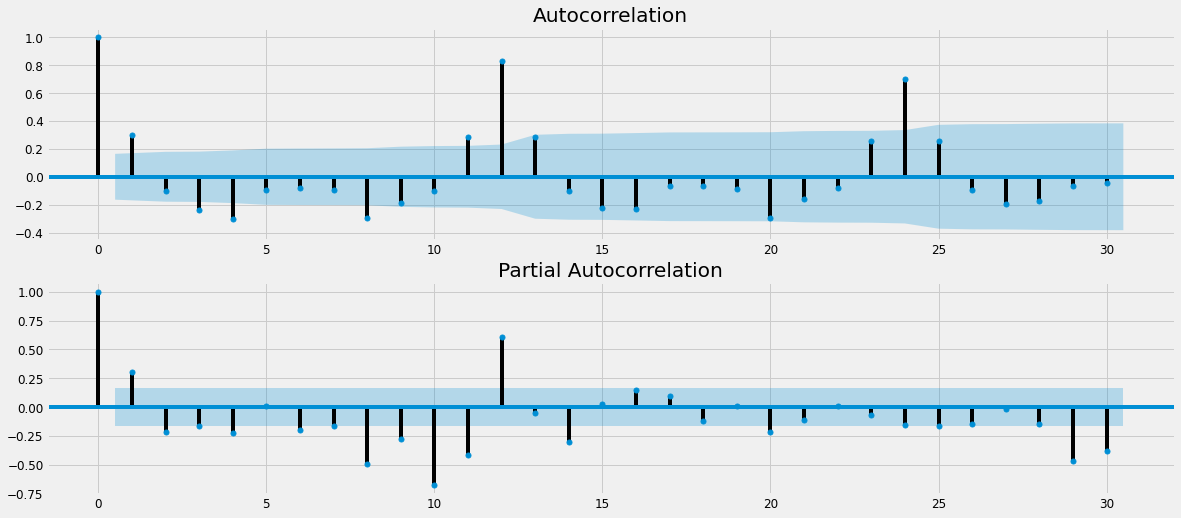

In [ ]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

## Interpretando diagramas ACF


ACF Shape | Modelo indicado |
- | - |
Exponencial, decayendo a cero | Modelo autorregresivo. Utilice el gráfico de autocorrelación parcial para identificar el orden del modelo autorregresivo |
Alternancia positiva y negativa, decayendo a cero Modelo autorregresivo.  | Use el gráfico de autocorrelación parcial para ayudar a identificar el orden. |
Uno o más picos, el resto son esencialmente cero | Modelo de media móvil, orden identificado por donde la trama se convierte en cero.  |
Decaimiento, comenzando después de algunos retrasos | Modelo mixto autorregresivo y de media móvil (ARMA). |
Todo cero o cerca de cero | Los datos son esencialmente aleatorios.  |
Valores altos a intervalos fijos | Incluye término estacional autorregresivo.  |
Sin descomposición a cero | La serie no es estacionaria |

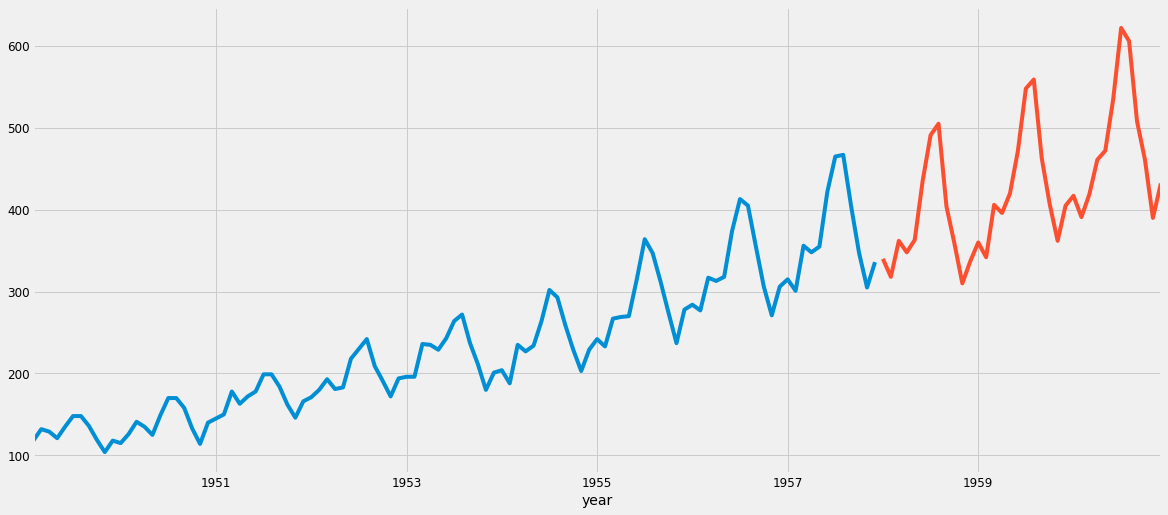

In [ ]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()

### Auto ARIMA

In [ ]:
#building the model
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=951.394, BIC=967.374, Fit time=0.351 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=994.463, BIC=999.790, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=988.112, BIC=996.102, Fit time=0.068 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=983.428, BIC=991.418, Fit time=0.067 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=963.447, BIC=976.764, Fit time=0.240 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=958.728, BIC=977.372, Fit time=0.381 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=960.893, BIC=974.210, Fit time=0.303 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=965.199, BIC=983.843, Fit time=0.420 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=980.464, BIC=991.117, Fit time=0.104 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 0, 0, 1);

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 1, 3),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

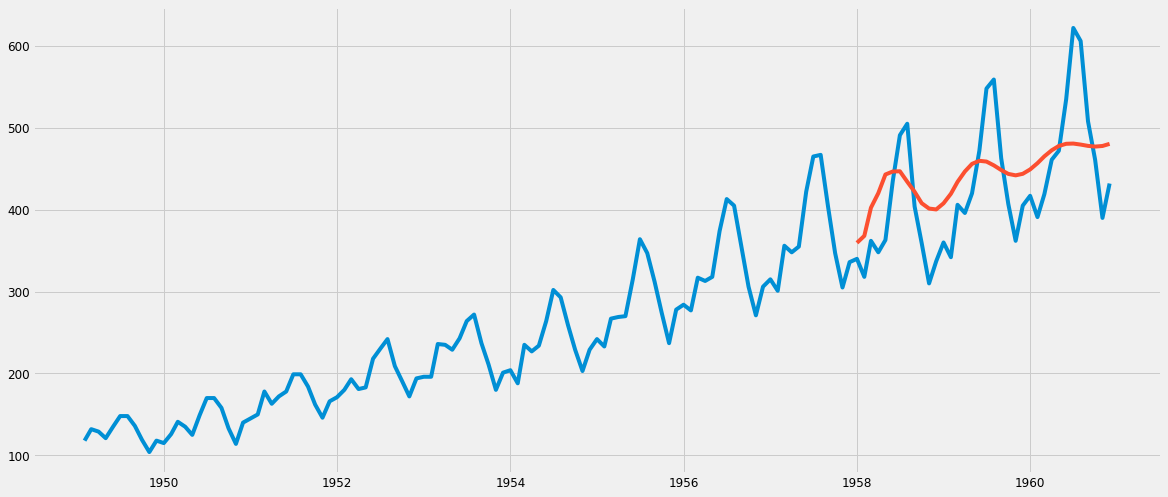

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [ ]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.375164,52.589898,48.129524,3822.936297,0.019482,NaN,61.829898


## Promedio móvil integrado estacional autorregresivo (SARIMA)
El promedio móvil integrado estacional autorregresivo, SARIMA o ARIMA estacional, es una extensión de ARIMA que admite explícitamente datos de series temporales univariantes con un componente estacional.

Agrega tres nuevos hiperparámetros para especificar la autorregresión (AR), la diferenciación (I) y el promedio móvil (MA) para el componente estacional de la serie, así como un parámetro adicional para el período de estacionalidad.

__Elementos de tendencia:__

Hay tres elementos de tendencia que requieren configuración. Son los mismos que el modelo ARIMA, específicamente:

- p: orden de tendencia de autorregresión.
- d: orden de diferencia de tendencia.
- q: tendencia de la media móvil.

__Elementos estacionales:__

Hay cuatro elementos estacionales que no forman parte de ARIMA que deben configurarse; son:

- P: orden autorregresivo estacional.
- D: orden de diferencia estacional.
- Q: orden de media móvil estacional.
- m: el número de pasos de tiempo para un solo período estacional. Por ejemplo, una S de 12 para datos mensuales sugiere un ciclo estacional anual.

__Notación SARIMA:__
SARIMA (p, d, q) (P, D, Q, m)

In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [ ]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 70.5287486623797, MSE:4974.304387881127


Text(0.5, 1.0, 'RMSE: 70.5287')

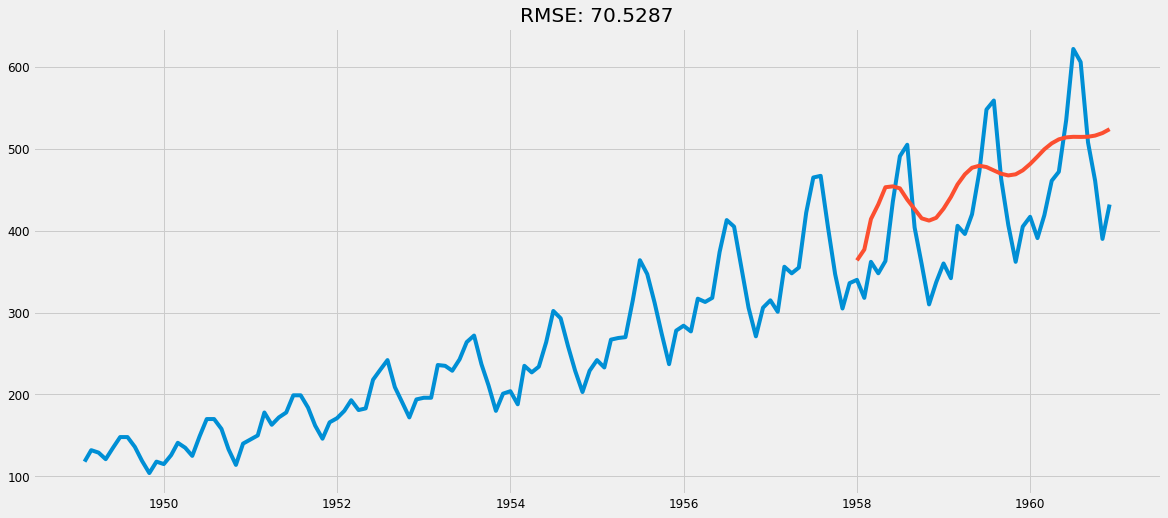

In [ ]:
plt.plot(y)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

In [ ]:
evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.18698,63.31679,65.710901,4974.304388,0.026296,NaN,70.528749


### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [ ]:
#building the model
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
model.fit(train)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 6); AIC=929.234, BIC=950.542, Fit time=1.114 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 6); AIC=994.463, BIC=999.790, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 6); AIC=988.919, BIC=999.572, Fit time=0.132 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 6); AIC=985.359, BIC=996.013, Fit time=0.168 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 6); AIC=948.976, BIC=967.620, Fit time=0.793 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 6); AIC=821.420, BIC=845.391, Fit time=1.483 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 0, 6); AIC=820.884, BIC=842.192, Fit time=1.383 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 0, 0, 6); AIC=816.494, BIC=835.138, Fit time=1.098 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 0, 6); AIC=818.929, BIC=834.910, Fit time=0.584 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 0, 0, 6);

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 4),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 0, 6), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()

In [ ]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Prediction'])

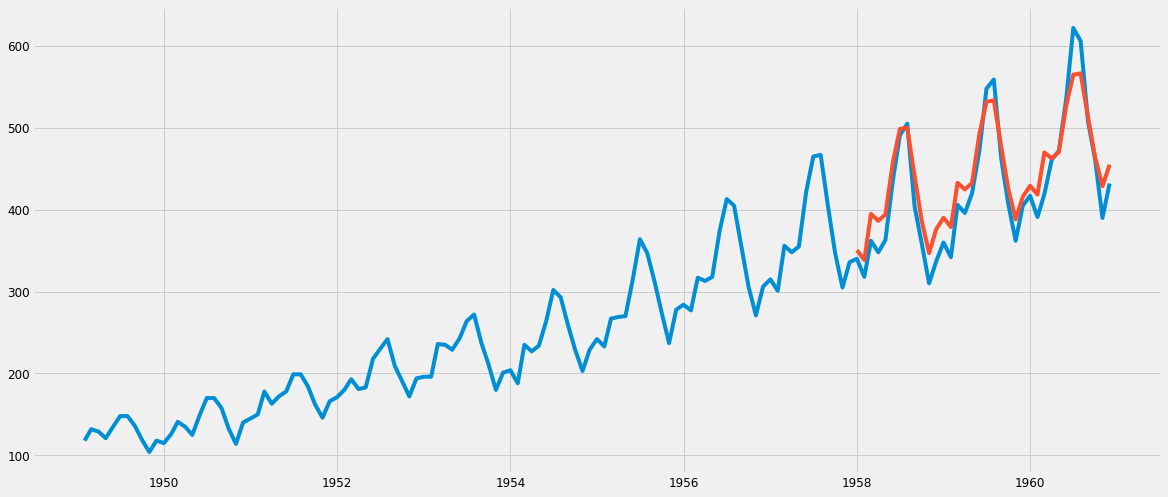

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [ ]:
evaluate_forecast(y[start_index:end_index], forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.878503,23.443494,24.222665,743.354721,0.004299,NaN,27.264532


### Tuned SARIMA

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [ ]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1471.5894402561958
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1319.9928811147315
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1096.7826572338538
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1005.4359790042608
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1105.737903034085


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so infer

ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:992.5677468085133
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:942.224950168512


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:852.1859541589661
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1322.5903474285726
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1183.157255991762


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:989.5448292769571
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:903.9207098606216
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1009.8928478558232


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:906.9760840359625
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:858.413015930409


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:785.0920712347818
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:984.4875572346155
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:935.318479671892
ARIMA(0, 1, 0)x(0, 1, 0, 6)12 - AIC:989.8626044826935
ARIMA(0, 1, 0)x(0, 1, 1, 6)12 - AIC:845.5177330594203
ARIMA(0, 1, 0)x(1, 0, 0, 6)12 - AIC:943.8322183884749


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so infer

ARIMA(0, 1, 0)x(1, 0, 1, 6)12 - AIC:895.3070514556366
ARIMA(0, 1, 0)x(1, 1, 0, 6)12 - AIC:700.1868931523687
ARIMA(0, 1, 0)x(1, 1, 1, 6)12 - AIC:694.5935065736841
ARIMA(0, 1, 1)x(0, 0, 0, 6)12 - AIC:964.9494014567993
ARIMA(0, 1, 1)x(0, 0, 1, 6)12 - AIC:916.1835214164046
ARIMA(0, 1, 1)x(0, 1, 0, 6)12 - AIC:970.2058039298502


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so infer

ARIMA(0, 1, 1)x(0, 1, 1, 6)12 - AIC:829.3905974836489
ARIMA(0, 1, 1)x(1, 0, 0, 6)12 - AIC:933.1971962173324
ARIMA(0, 1, 1)x(1, 0, 1, 6)12 - AIC:879.2724953163256


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(0, 1, 1)x(1, 1, 0, 6)12 - AIC:691.8986810545232


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(0, 1, 1)x(1, 1, 1, 6)12 - AIC:676.1162625989539
ARIMA(1, 0, 0)x(0, 0, 0, 6)12 - AIC:995.0872335459023
ARIMA(1, 0, 0)x(0, 0, 1, 6)12 - AIC:946.0213053945042
ARIMA(1, 0, 0)x(0, 1, 0, 6)12 - AIC:992.3210476491263


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(1, 0, 0)x(0, 1, 1, 6)12 - AIC:854.1006983844089
ARIMA(1, 0, 0)x(1, 0, 0, 6)12 - AIC:945.824994915169
ARIMA(1, 0, 0)x(1, 0, 1, 6)12 - AIC:897.2332953680387


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(1, 0, 0)x(1, 1, 0, 6)12 - AIC:700.7529216471441
ARIMA(1, 0, 0)x(1, 1, 1, 6)12 - AIC:700.9426911326723
ARIMA(1, 0, 1)x(0, 0, 0, 6)12 - AIC:975.3565669152902


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred freque

ARIMA(1, 0, 1)x(0, 0, 1, 6)12 - AIC:927.1005482753977
ARIMA(1, 0, 1)x(0, 1, 0, 6)12 - AIC:967.4612507661539
ARIMA(1, 0, 1)x(0, 1, 1, 6)12 - AIC:836.851248951029
ARIMA(1, 0, 1)x(1, 0, 0, 6)12 - AIC:935.208353589516
ARIMA(1, 0, 1)x(1, 0, 1, 6)12 - AIC:876.2562823874784


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(1, 0, 1)x(1, 1, 0, 6)12 - AIC:693.6979953241223


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(1, 0, 1)x(1, 1, 1, 6)12 - AIC:684.4099922937718
ARIMA(1, 1, 0)x(0, 0, 0, 6)12 - AIC:977.9057542721393
ARIMA(1, 1, 0)x(0, 0, 1, 6)12 - AIC:928.7238491320207
ARIMA(1, 1, 0)x(0, 1, 0, 6)12 - AIC:976.0432050448763
ARIMA(1, 1, 0)x(0, 1, 1, 6)12 - AIC:835.88828082212
ARIMA(1, 1, 0)x(1, 0, 0, 6)12 - AIC:927.7462242532101


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so infer

ARIMA(1, 1, 0)x(1, 0, 1, 6)12 - AIC:885.4070402292086
ARIMA(1, 1, 0)x(1, 1, 0, 6)12 - AIC:686.2396845894478


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(1, 1, 0)x(1, 1, 1, 6)12 - AIC:684.1667524970782
ARIMA(1, 1, 1)x(0, 0, 0, 6)12 - AIC:962.9055074926869
ARIMA(1, 1, 1)x(0, 0, 1, 6)12 - AIC:913.179495306321
ARIMA(1, 1, 1)x(0, 1, 0, 6)12 - AIC:969.0402471856139


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(1, 1, 1)x(0, 1, 1, 6)12 - AIC:832.770226318386
ARIMA(1, 1, 1)x(1, 0, 0, 6)12 - AIC:921.9213046743037


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(1, 1, 1)x(1, 0, 1, 6)12 - AIC:878.8482723850135
ARIMA(1, 1, 1)x(1, 1, 0, 6)12 - AIC:686.7731070418848


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



ARIMA(1, 1, 1)x(1, 1, 1, 6)12 - AIC:678.0222355416008


In [ ]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        passengers   No. Observations:                  107
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -334.058
Date:                           Thu, 11 Jun 2020   AIC                            676.116
Time:                                   23:25:21   BIC                            686.203
Sample:                               02-01-1949   HQIC                           680.188
                                    - 12-01-1957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4543      0.083     -5.490      0.000      -0.617      -0.292
ar.S.L6       -1.0894      0.017    -63.852      0.000      -1.123      -1.056
ma.S.L6        2.3103      0.630      3.668      0.000       1.076       3.545
sigma2        15.4815      8.038      1.926      0.054      -0.272      31.235
===================================================================================
Ljung-Box (Q):                       44.28   Jarque-Bera (JB):                 1.95
Prob(Q):                              0.30   Prob(JB):                         0.38
Heteroskedasticity (H):               0.60   Skew:                             0.36
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

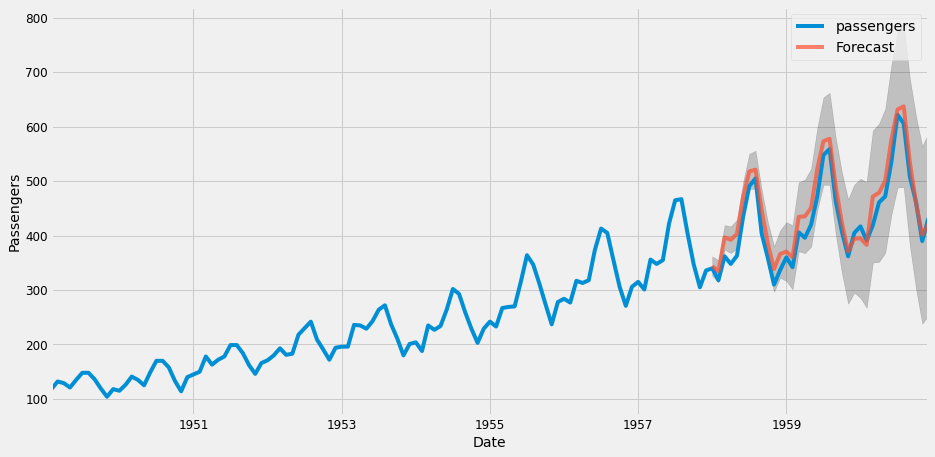

In [ ]:
pred_ci = pred.conf_int()
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

__Diagnóstico del modelo:__
- Nuestra principal preocupación es garantizar que los residuos de nuestro modelo no estén correlacionados y normalmente se distribuyan con media cero.
- Si el modelo estacional ARIMA no satisface estas propiedades, es una buena indicación de que puede mejorarse aún más.

El diagnóstico del modelo sugiere que el modelo residual se distribuye normalmente en función de lo siguiente:

- En la gráfica superior derecha, la línea roja de KDE sigue de cerca con la línea N (0,1). Donde, N (0,1) es la notación estándar para una distribución normal con media 0 y desviación estándar de 1. Esta es una buena indicación de que los residuos se distribuyen normalmente.
- La gráfica qq en la parte inferior izquierda muestra que la distribución ordenada de los residuos (puntos azules) sigue la tendencia lineal de las muestras tomadas de una distribución normal estándar. Nuevamente, esta es una fuerte indicación de que los residuos se distribuyen normalmente.
- Los residuos a lo largo del tiempo (gráfico superior izquierdo) no muestran ninguna estacionalidad obvia y parecen ser ruido blanco.
- Esto se confirma mediante el gráfico de autocorrelación (es decir, correlograma) en la parte inferior derecha, que muestra que los residuos de series temporales tienen una baja correlación con versiones rezagadas de sí mismo.

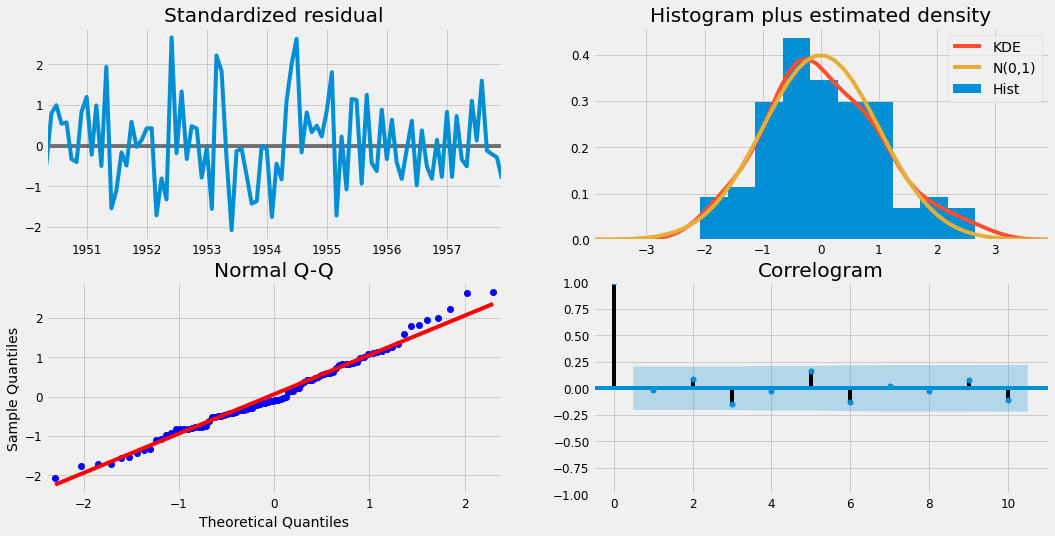

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean.values
y_truth = y[start_index:end_index].passengers.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 781.9


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 27.96


In [ ]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.872203,24.74044,26.217271,781.900604,0.004216,5.933083,27.962486


## Prophet
- [Prophet] (https://facebook.github.io/prophet/) es un software de código abierto lanzado por el equipo de Core Data Science de Facebook.
- Prophet es un procedimiento para pronosticar datos de series de tiempo basado en un modelo aditivo / multiplicativo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, más los efectos de vacaciones.
- Funciona mejor con series de tiempo que tienen fuertes efectos estacionales y varias temporadas de datos históricos.
- Prophet es robusto ante los datos faltantes y los cambios en la tendencia, y generalmente maneja bien los valores atípicos.
- El paquete Prophet proporciona parámetros intuitivos que son fáciles de ajustar.

__Parámetros de tendencia__

- crecimiento: 'lineal' o 'logístico' para especificar una tendencia lineal o logística
- puntos de cambio: lista de fechas en las que se incluyen posibles puntos de cambio (automático si no se especifica)
- n_changepoints: si no se proporcionan puntos de cambio, puede proporcionar el número de puntos de cambio que se incluirán automáticamente
- changepoint_prior_scale: parámetro para cambiar la flexibilidad de la selección automática de puntos de cambio
 

__Estacionalidad y parámetros de vacaciones__

- Estacionalidad anual: ajusta la estacionalidad anual
- semanal_estacionalidad: Ajustar estacionalidad semanal
- daily_seasonality: ajusta la estacionalidad diaria
- vacaciones: marco de datos del feed que contiene el nombre y la fecha de vacaciones
- seasonality_prior_scale: parámetro para cambiar la fuerza del modelo de estacionalidad
- holiday_prior_scale: parámetro para cambiar la fuerza del modelo de vacaciones

Prophet requiere que los nombres de las variables en la serie de tiempo sean:

- y - Target
- ds - Fecha y hora

In [ ]:
train.head()

,passengers
year,
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135


In [ ]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.passengers.values

In [ ]:
train_prophet.head()

,ds,y
0,1949-02-01,118
1,1949-03-01,132
2,1949-04-01,129
3,1949-05-01,121
4,1949-06-01,135


In [ ]:
from fbprophet import Prophet

#instantiate Prophet with only yearly seasonality as our data is monthly 
model = Prophet( yearly_seasonality=True, seasonality_mode = 'multiplicative')
model.fit(train_prophet) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 36, freq = 'MS') 
future.tail()

,ds
138,1960-08-01
139,1960-09-01
140,1960-10-01
141,1960-11-01
142,1960-12-01


In [ ]:
forecast.columns

Index(['Prediction'], dtype='object')

In [ ]:

# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
138,1960-08-01,617.535627,599.902774,633.885587
139,1960-09-01,534.714295,520.270094,549.717873
140,1960-10-01,466.515339,451.200231,480.367703
141,1960-11-01,414.086868,400.692882,426.642947
142,1960-12-01,460.309413,444.743127,475.516120


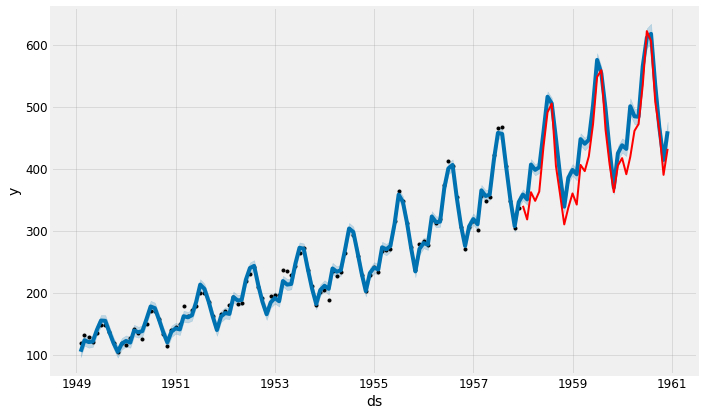

In [ ]:
fig = model.plot(forecast)
#plot the predictions for validation set

plt.plot(valid, label='Valid', color = 'red', linewidth = 2)

plt.show()

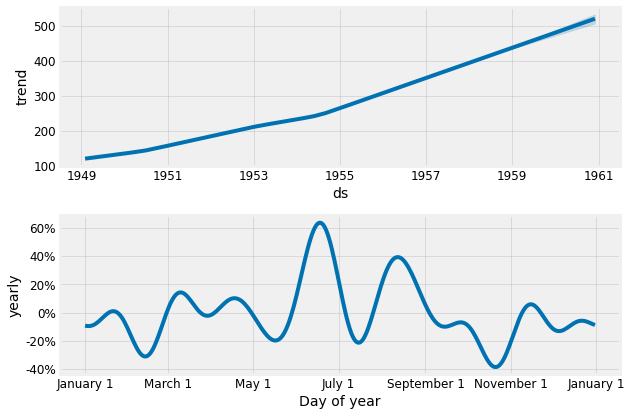

In [ ]:
model.plot_components(forecast);

In [ ]:
y_prophet = pd.DataFrame()
y_prophet['ds'] = y.index
y_prophet['y'] = y.passengers.values

In [ ]:
y_prophet = y_prophet.set_index('ds')
forecast_prophet = forecast.set_index('ds')

In [ ]:
evaluate_forecast(y_prophet.y[start_index:end_index], forecast_prophet.yhat[start_index:end_index])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.820879,29.087435,27.918218,1095.915421,0.006448,7.291709,33.104613


## Mejora de modelos de pronóstico de series temporales

1. Optimización de hiperparamter: Encontrar los parámetros óptimos de los modelos ARIMA / Prophet.

2. Variables exógenas (SARIMAX): incluidas variables externas como campañas, vacaciones, eventos, calamidades naturales, etc.

3. [Combinando modelos para predicciones de series de tiempo avanzadas] (https://www.kdnuggets.com/2016/11/combining-different-methods-create-advanced-time-series-prediction.html)

4. [Red de memoria de corto plazo (LSTM)] (https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)